In [1]:
import gym
import gym_futbol
from stable_baselines3 import A2C
import matplotlib.pyplot as plt
import pymunk
from IPython import display
import utils

pygame 2.1.0 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Basics

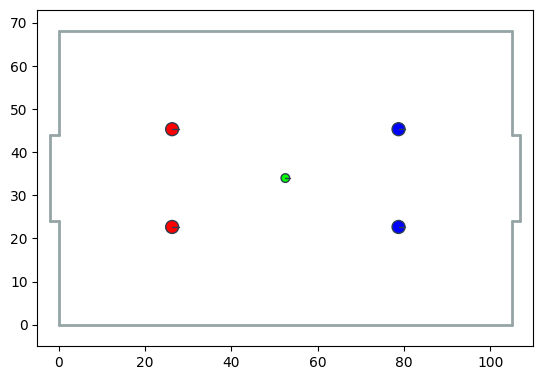

In [2]:
env = gym.make("Futbol2v2-v1")
env.render()

In [3]:
env.action_space

MultiDiscrete([5 5 5 5])

In [4]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Learning model

In [5]:
import stable_baselines3.common.results_plotter as results_plotter
from stable_baselines3.common.env_util import make_vec_env

log_dir = "logs/"
timesteps = 100000

env = gym.make("Futbol2v2-v1")
env = make_vec_env(lambda: env, n_envs=4, monitor_dir=log_dir)
model = A2C("MlpPolicy", env, device='cpu')
model.learn(timesteps, progress_bar=True)
model.save("models/footbol2v2-a2c")

Output()

/home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


# Display model statistic

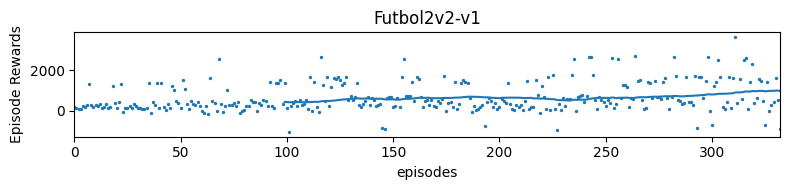

In [6]:
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

# Load model from file

In [7]:
model = A2C.load("models/footbol2v2-a2c", device="cpu")

# Run models

## Pygame
Run game with model in new windows with pygame

In [8]:
import pygame as pg
import pymunk.pygame_util

In [10]:
RES = WIDTH, HEIGHT = 600, 600
FPS = 60
pg.init()
surface = pg.display.set_mode(RES)
clock = pg.time.Clock()
draw_options = pymunk.pygame_util.DrawOptions(surface)

env = gym.make("Futbol2v2-v1", width=WIDTH-2, height=HEIGHT-2, player_radius=15, ball_radius=5)

def visualize_pygame(env, reward):
    surface.fill("black")
    o = pymunk.pygame_util.DrawOptions(surface)
    env.space.debug_draw(o)
    pg.display.flip()
    clock.tick(FPS)

utils.run_model(env, model, visualize_pygame)
env.close()
pg.quit()

## Matplotlib
Run model in notebook with matplotlib

KeyboardInterrupt: 

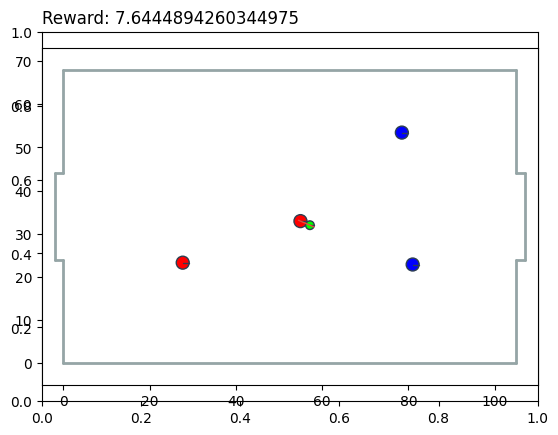

In [13]:
env = gym.make("Futbol2v2-v1")
utils.run_model(env, model, utils.visualize_matplotlib)